# Working with scverse objects in backed mode

In this tutorial we show how to work with scverse data objects without loading the full datasets in memory. AnnData and MuData objects are saved to disk as `.h5ad` and `.h5mu` files. These formats save [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) stores (via [h5py](https://docs.h5py.org/en/latest/index.html)) that can be accessed without loading heavy data matrices in memory (i.e. in _backed_ mode), as a "read-only" object. 

In this tutorial, we demonstrate how to work in backed mode for:
- quickly inspecting the content of an h5ad/h5mu file
- exploratory data analysis (e.g. plotting embeddings) 
- selecting a subset of interest in a very large dataset

In [1]:
from warnings import filterwarnings

# for datasets
import mudatasets
import muon as mu
import pandas as pd
import scanpy as sc

filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

/home/runner/miniconda3/envs/tutorials/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sc.set_figure_params(fontsize=18, figsize=[6, 6])

## Working with backed AnnData objects

Let's load an anndata object in memory

In [3]:
adata = sc.datasets.pbmc3k_processed()
adata = adata.raw.to_adata()  # Store raw counts in adata.X

  0%|          | 0.00/23.5M [00:00<?, ?B/s]

100%|██████████| 23.5M/23.5M [00:00<00:00, 274MB/s]

Let's check the size of this AnnData object (i.e. the amount of RAM needed to load it)

In [4]:
# Convenience method for computing the size of objects
def print_size_in_MB(x):
    print(f"{x.__sizeof__() / 1e6:.3} MB")

In [5]:
print_size_in_MB(adata)

21.1 MB


Now let's save this object in `.h5ad` format and re-load it in backed (on-disk) mode. 

In [6]:
adata.write_h5ad("./data/pbmc3k_processed_raw.h5ad")
adata = sc.read_h5ad("./data/pbmc3k_processed_raw.h5ad", backed=True)

Now the size of our AnnData object is about 3 MB, with the gene expression matrix saved only on disk

In [7]:
print_size_in_MB(adata)

3.15 MB


We can check whether an anndata object is loaded in backed mode using the `adata.isbacked` attribute

In [8]:
adata.isbacked

True

while the path to the file on disk is stored in `adata.filename`

In [9]:
adata.filename

PosixPath('data/pbmc3k_processed_raw.h5ad')

### Exploratory data analysis

When loading an h5ad file in backed mode, we can use all scverse functions that require to read the data without having in memory the full `adata.X` matrix. For example we can plot embeddings or gene expression matrices. The gene expression values for a given gene or set of genes are loaded from disk on the function call.

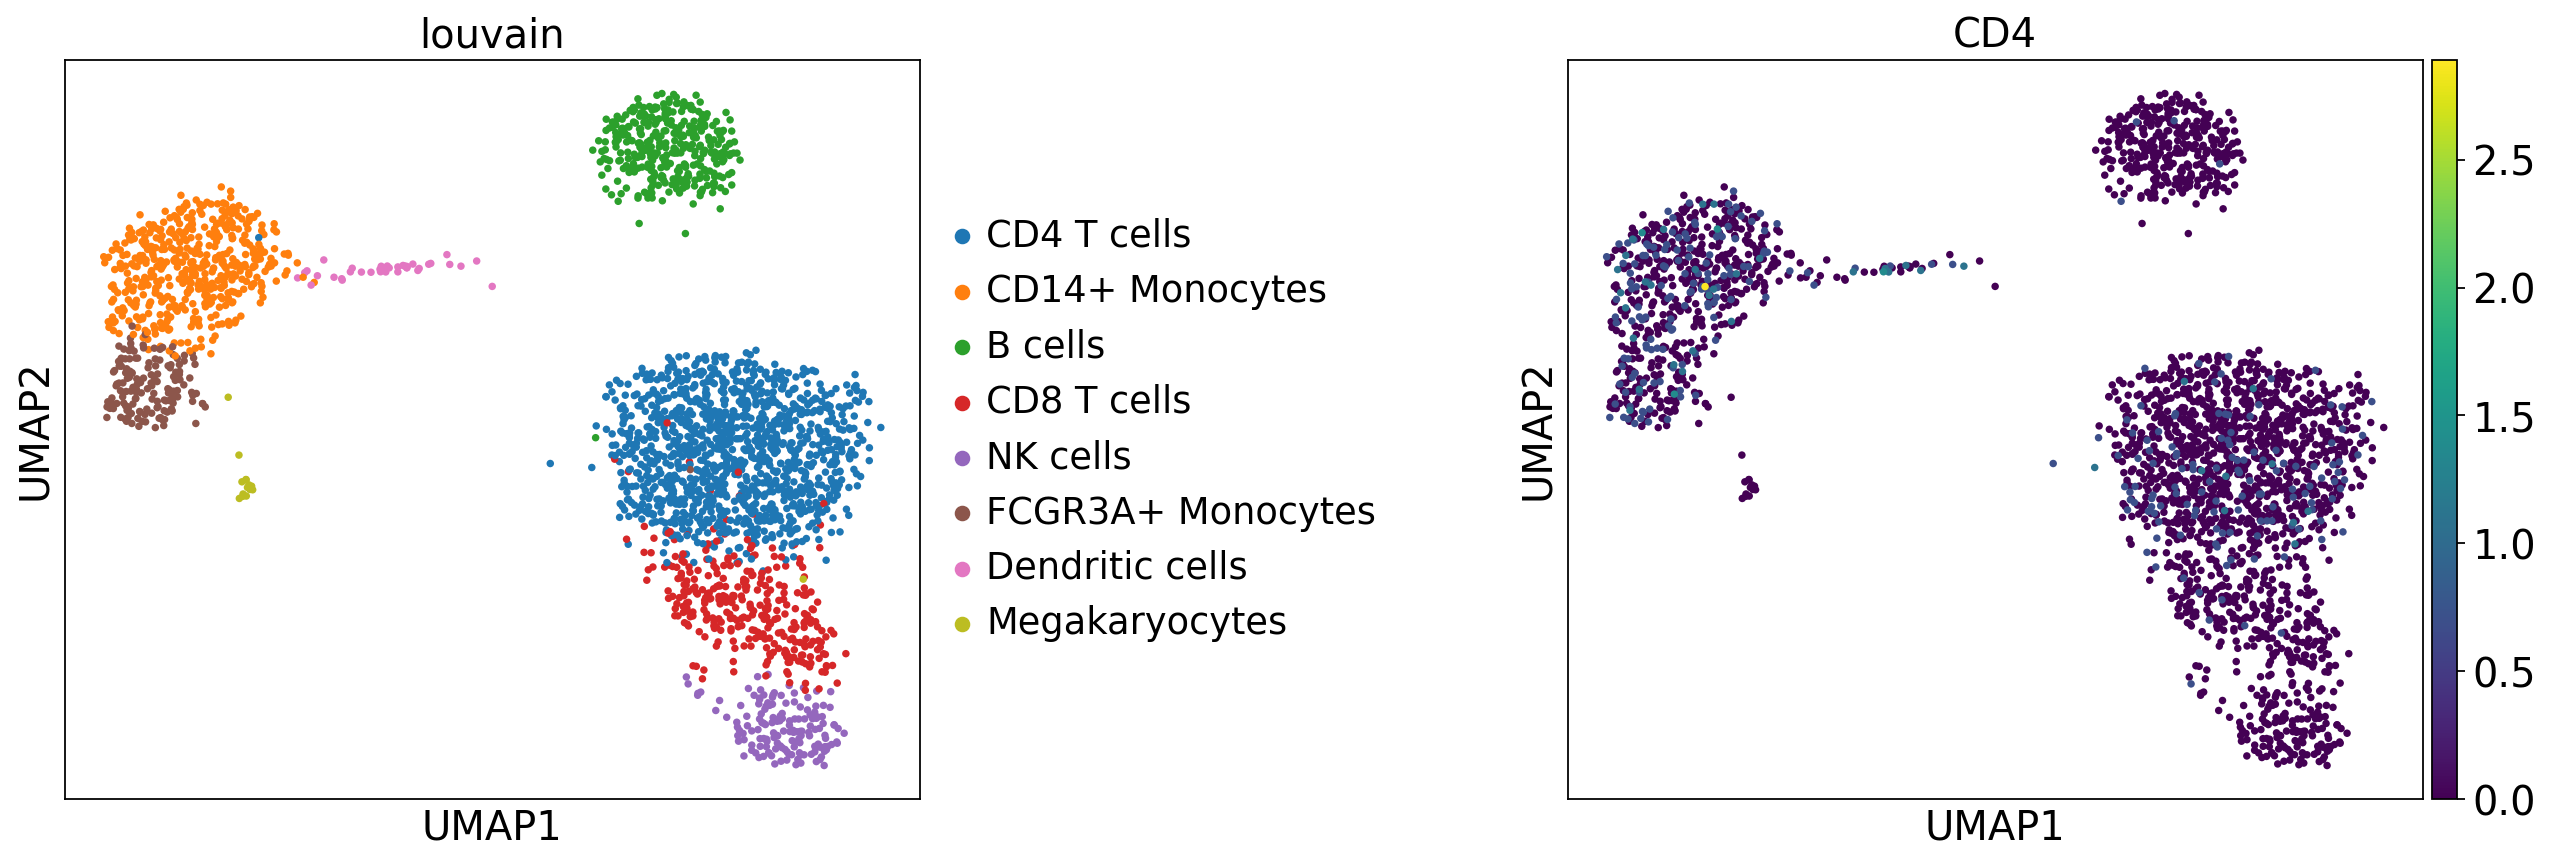

In [10]:
sc.pl.umap(adata, color=["louvain", "CD4"], wspace=0.6)

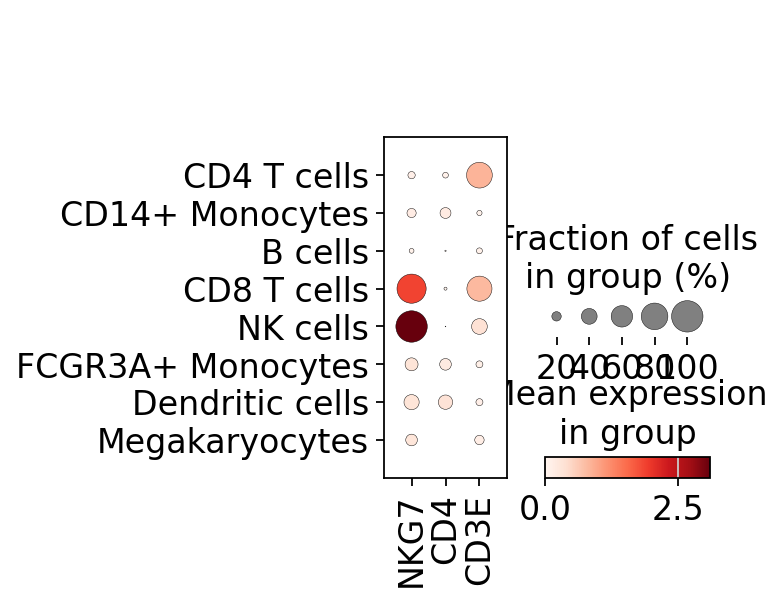

In [11]:
sc.pl.dotplot(adata, var_names=["NKG7", "CD4", "CD3E"], groupby="louvain")

The full gene expression matrix in `adata.X` is not loaded, but all the cell- and gene-level metadata is in memory and can be modified. Therefore we can run methods that modify obs/obsm/obsp. For example, we can compute KNN graphs and nearest neighbor embeddings

In [12]:
sc.pp.neighbors(adata, n_neighbors=20)
sc.tl.umap(adata)

Or we can perform clustering

In [13]:
sc.tl.leiden(adata, resolution=0.5, key_added="leiden_res0.5")

In [14]:
adata.obs

,n_genes,percent_mito,n_counts,louvain,leiden_res0.5
index,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,0
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,3
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,0
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,1
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,2
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14+ Monocytes,1
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B cells,3
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells,3


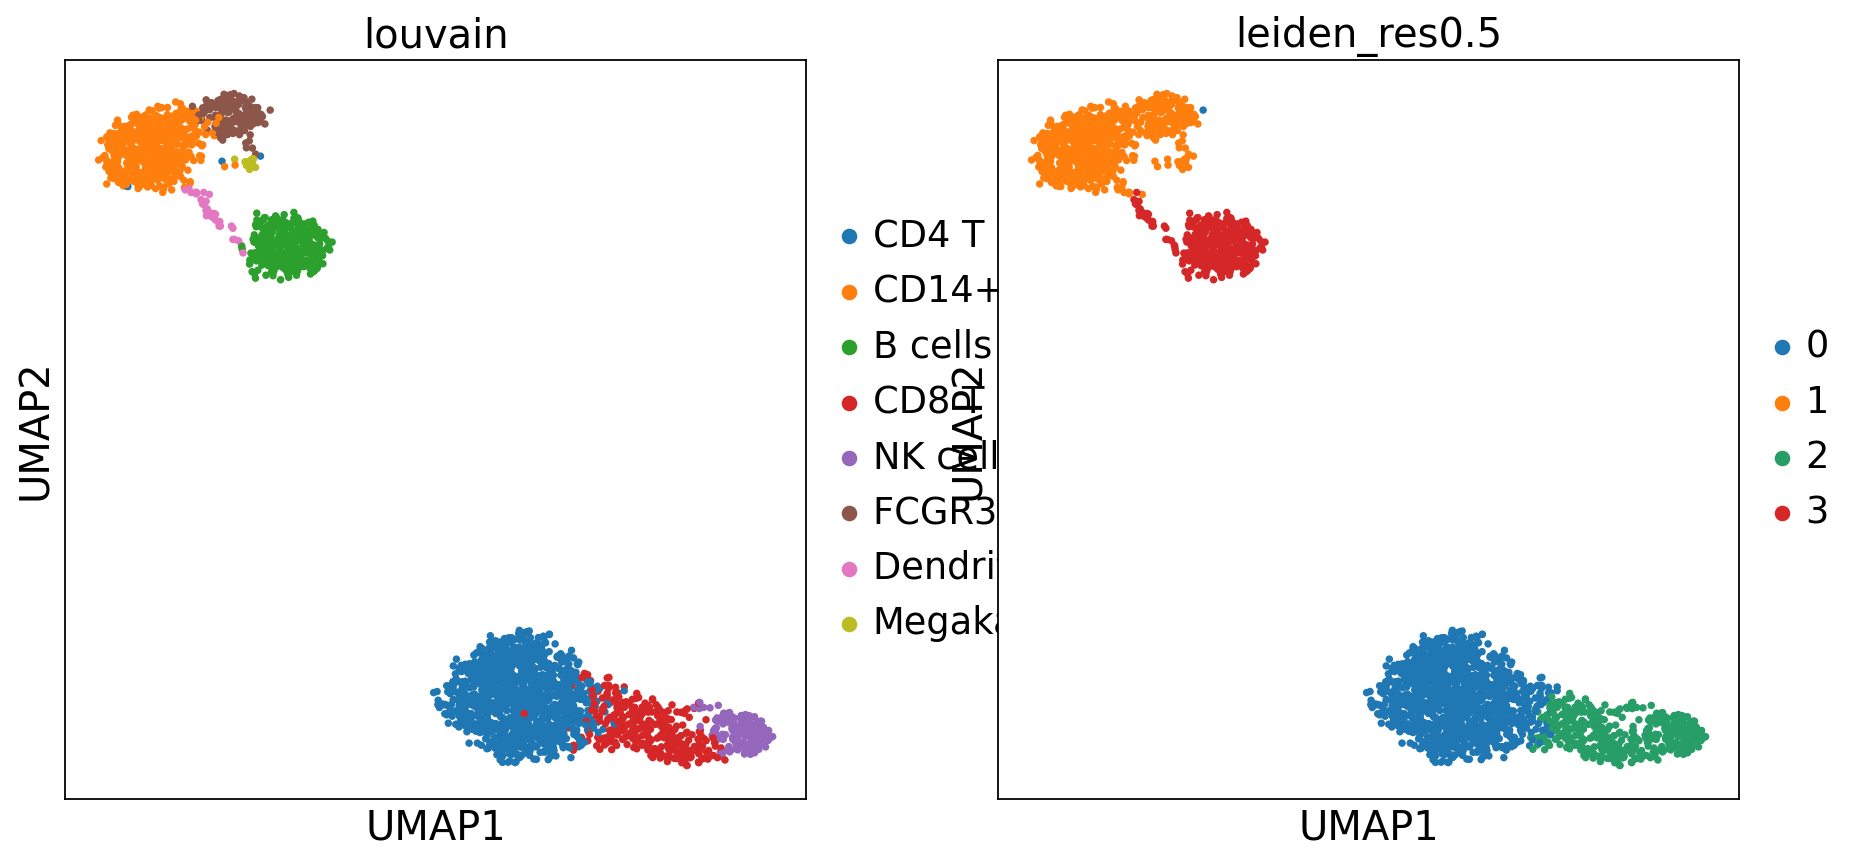

In [15]:
sc.pl.umap(adata, color=["louvain", "leiden_res0.5"])

### Extracting a subset of AnnData

Another common use-case for backed mode is to inspect a dataset to then select and save a subset of data that we are interested in using for analysis. 

For example, if we are interested in performing analysis just on T cells, we can subset the AnnData object and load in memory just the gene expression matrix of the subset of interest    

In [16]:
T_clusters = ["CD4 T cells", "CD8 T cells"]
adata_subset = adata[adata.obs["louvain"].isin(T_clusters)].to_memory()

In [17]:
adata_subset

AnnData object with n_obs × n_vars = 1460 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'leiden_res0.5'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'leiden_res0.5', 'leiden_res0.5_colors'
    obsm: 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [18]:
adata_subset.isbacked

False

If we want to keep working in backed mode with this data subset, we can copy it specifying a new `.h5ad` file on disk where this will be saved.

In [19]:
adata_subset = adata[adata.obs["louvain"].isin(T_clusters)].copy(filename="./data/pbmc3k_processed_CD4Tcells.h5ad")

In [20]:
adata_subset

AnnData object with n_obs × n_vars = 1460 × 13714 backed at 'data/pbmc3k_processed_CD4Tcells.h5ad'
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'leiden_res0.5'
    var: 'n_cells'
    uns: 'draw_graph', 'leiden_res0.5', 'leiden_res0.5_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [21]:
adata_subset.isbacked

True

### Things you can't do with AnnData in backed mode

Backed mode loads gene expression matrices in "read-only" mode, so functions that attempt to modify `adata.X` will throw errors. 

For example, normalizing with

```python
sc.pp.normalize_total(adata)
```
Throws the following error
```pytb
AttributeError: 'SparseDataset' object has no attribute 'sum'
```

but the gene expression matrix can be accessed directly using numerical indices.

In [22]:
adata.X[:, 0 : adata.n_vars]

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 2238732 stored elements and shape (2638, 13714)>

Of note, in the current version of `anndata` the matrices in `adata.layers` are __not__ backed.

Another caveat is that an object can be opened in backed mode only from one process/notebook simultaneously. Attempting to load it (with `sc.read_h5ad`) will throw an Input/Output error. 

### Save changes made to backed AnnData

We can save the changes we've made to the backed anndata by writing back to the linked h5ad file.

In [23]:
adata.write_h5ad()

If we re-load this object from file, we will find all the updated information in the `obs` slot

In [24]:
adata = sc.read_h5ad("./data/pbmc3k_processed_raw.h5ad", backed=True)

In [25]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714 backed at 'data/pbmc3k_processed_raw.h5ad'
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'leiden_res0.5'
    var: 'n_cells'
    uns: 'draw_graph', 'leiden_res0.5', 'leiden_res0.5_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

We can also save to a different file

In [26]:
adata.write_h5ad("./data/pbmc3k_processed_newclustering.h5ad")

## Working with backed MuData objects

Working with data on disk is particularly useful when working with data modalities different from gene expression, where the number of measured features is typically larger. For example, in data from scATAC-seq experiments accessibility is usually measured at hundreds of thousands of genomic regions, making feature x cell matrices prohibitively large to load in memory. 

For this application, also MuData objects support working in backed mode.


In [27]:
# Download mudata object and save in h5mu format
mdata = mudatasets.load("pbmc10k_multiome")
mdata["rna"].var_names_make_unique()
mdata.write_h5mu("./data/pbmc10k_multiome.h5mu")

  0%|          | 0/19810 [00:00<?, ?it/s, 154.8MiB, filtered_feature_bc_matrix.h5, pbmc10k_multiome]

 15%|█▌        | 3027/19810 [00:00<00:00, 30229.38it/s, 154.8MiB, filtered_feature_bc_matrix.h5, pbmc10k_multiome]

 31%|███       | 6050/19810 [00:00<00:00, 25071.05it/s, 154.8MiB, filtered_feature_bc_matrix.h5, pbmc10k_multiome]

 44%|████▎     | 8651/19810 [00:00<00:00, 25453.38it/s, 154.8MiB, filtered_feature_bc_matrix.h5, pbmc10k_multiome]

 57%|█████▋    | 11231/19810 [00:00<00:00, 23837.16it/s, 154.8MiB, filtered_feature_bc_matrix.h5, pbmc10k_multiome]

 72%|███████▏  | 14253/19810 [00:00<00:00, 25557.74it/s, 154.8MiB, filtered_feature_bc_matrix.h5, pbmc10k_multiome]

 85%|████████▍ | 16838/19810 [00:00<00:00, 24516.62it/s, 154.8MiB, filtered_feature_bc_matrix.h5, pbmc10k_multiome]

100%|██████████| 19810/19810 [00:00<00:00, 25603.93it/s, 154.8MiB, filtered_feature_bc_matrix.h5, pbmc10k_multiome]


/home/runner/miniconda3/envs/tutorials/lib/python3.12/site-packages/mudatasets/core.py:203: UserWarning: Dataset is in the 10X .h5 format and can't be loaded as backed.
  warn("Dataset is in the 10X .h5 format and can't be loaded as backed.")


■ Loading filtered_feature_bc_matrix.h5...


/home/runner/miniconda3/envs/tutorials/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from /home/runner/mudatasets/pbmc10k_multiome/filtered_feature_bc_matrix.h5


/home/runner/miniconda3/envs/tutorials/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/home/runner/miniconda3/envs/tutorials/lib/python3.12/site-packages/mudata/_core/mudata.py:947: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


We can see that the slot storing the scATAC accessibility matrix is quite large when loaded in memory

In [28]:
mdata["atac"].isbacked

False

In [29]:
print_size_in_MB(mdata["atac"])

7.14e+02 MB


Let's now load the `.h5mu` object in backed mode using the `read_h5mu` function from the muon package.

In [30]:
mdata = mu.read_h5mu("./data/pbmc10k_multiome.h5mu", backed=True)

In [31]:
mdata

MuData object with n_obs × n_vars = 11909 × 144978 backed at 'data/pbmc10k_multiome.h5mu'
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	11909 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	11909 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

Now the feature x cell matrices for both modalities are on-disk, and the object takes up a lot less memory.

In [32]:
print_size_in_MB(mdata["atac"])

28.9 MB


### Working with only one modality in memory

If we are analysing a multi-modal dataset, we might need to handle and process only one modality at a time. In this case we can keep the other modality on disk to reduce memory usage. For example, we can load the RNA modality only, to run clustering. 

In [33]:
mdata.mod["rna"] = mdata.mod["rna"].to_memory()

In [34]:
mdata["rna"].isbacked

False

In [35]:
mdata["atac"].isbacked

True

Now we can run preprocessing of the expression data

In [36]:
rna = mdata.mod["rna"]

## Normalization
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

## HVG selection
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)

## Dim reduction and embeddings
sc.tl.pca(rna, svd_solver="arpack")
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)
sc.tl.umap(rna)
sc.tl.leiden(rna, resolution=1.0)

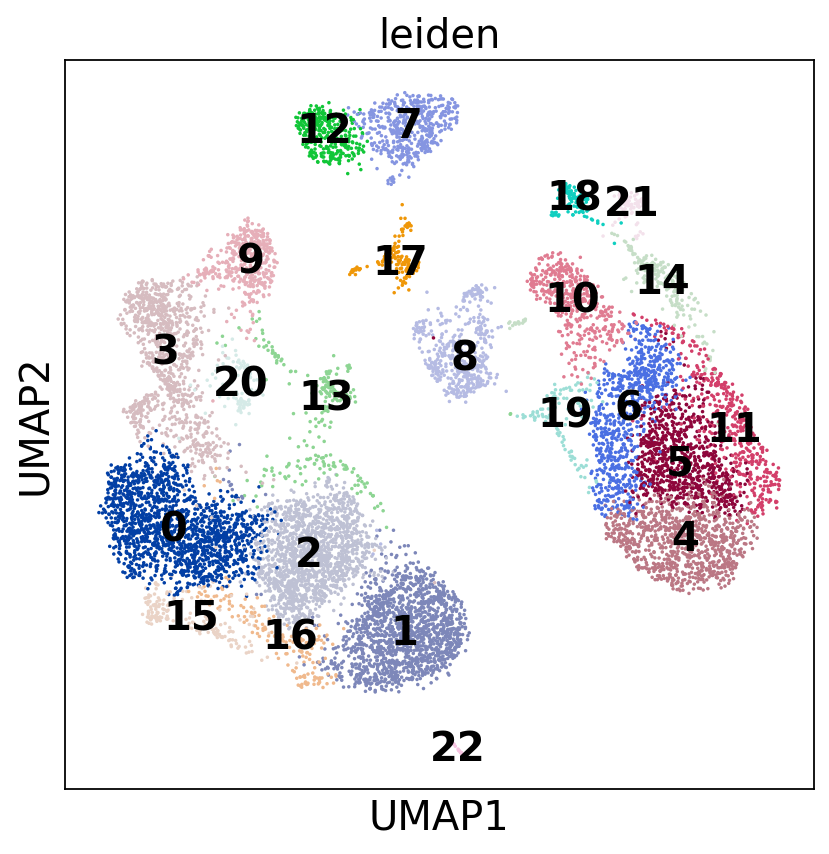

In [37]:
sc.pl.umap(rna, color="leiden", legend_loc="on data")

Now all the changes are saved in the MuData object.

In [38]:
mdata["rna"]

AnnData object with n_obs × n_vars = 11909 × 36601
    obs: 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can save changes to the h5mu file on disk, without needing to load the ATAC modality dataset

In [39]:
## Save log-normalized files in layers
# (write_h5mu doesn't rewrite .X if the file is in backed mode)
mdata["rna"].layers["lognorm_counts"] = mdata["rna"].X.copy()

mdata.write_h5mu()

Now we can reload the updated object to have both modalities on disk

In [40]:
mdata = mu.read_h5mu("./data/pbmc10k_multiome.h5mu", backed=True)

In [41]:
mdata

MuData object with n_obs × n_vars = 11909 × 144978 backed at 'data/pbmc10k_multiome.h5mu'
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	11909 x 36601
      obs:	'leiden'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'lognorm_counts'
      obsp:	'connectivities', 'distances'
    atac:	11909 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [42]:
mdata["atac"].isbacked and mdata["rna"].isbacked

True

### Extracting a MuData subset

Similarly to the AnnData case, we can use the backed mode to identify a subset of data that we are interested in, and save it as a smaller object to load into memory. 

For example, we could subset the PBMC dataset to include only the T and NK cells (clusters expressing CD2)

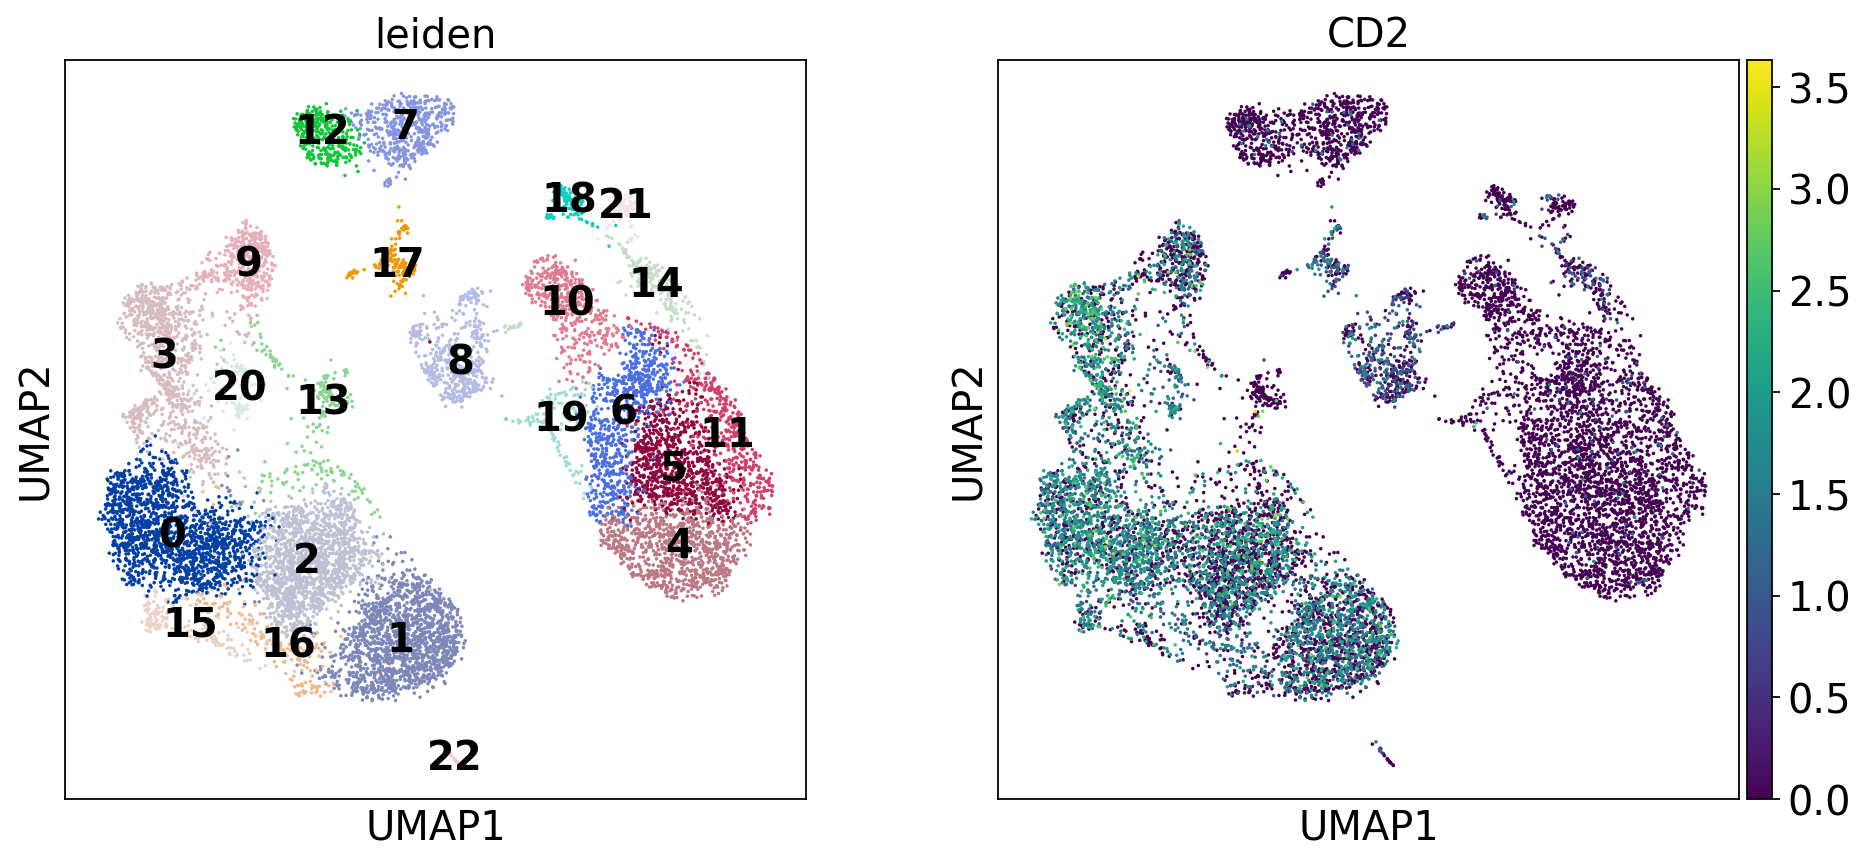

In [43]:
sc.pl.umap(mdata["rna"], color=["leiden", "CD2"], layer="lognorm_counts", legend_loc="on data")

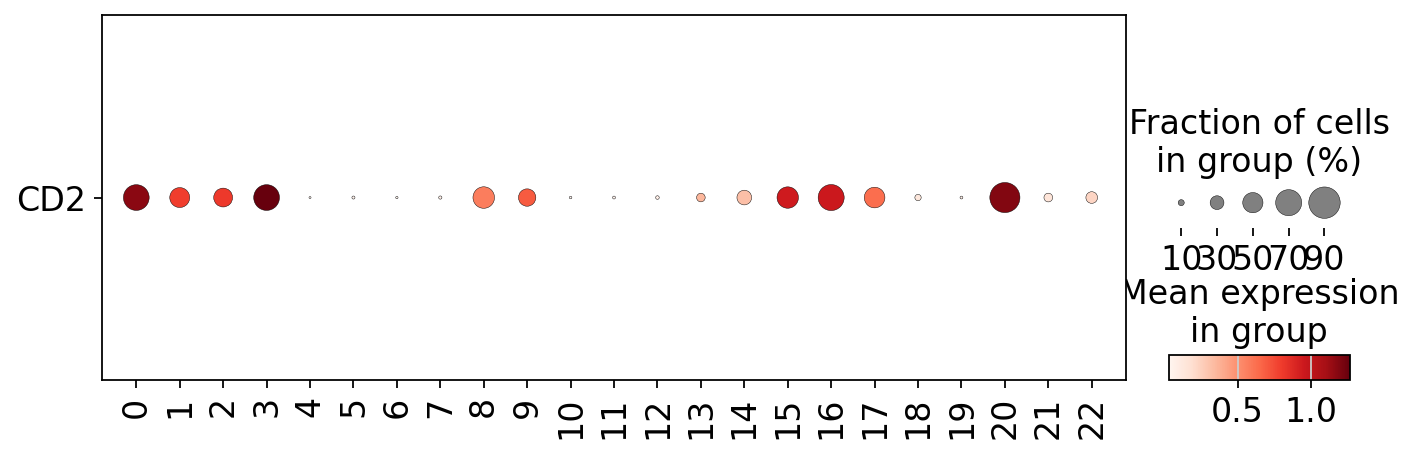

In [44]:
sc.pl.dotplot(mdata["rna"], var_names=["CD2"], groupby="leiden", figsize=(10, 3), swap_axes=True)

In [45]:
nkt_cell_clusters = ["19", "20", "13", "11", "9", "14", "19", "5", "0", "1", "3"]
mdata[mdata.obs["rna:leiden"].isin(nkt_cell_clusters)]

View of MuData object with n_obs × n_vars = 6381 × 144978 backed at 'data/pbmc10k_multiome.h5mu'
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	6381 x 36601
      obs:	'leiden'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'lognorm_counts'
      obsp:	'connectivities', 'distances'
    atac:	6381 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

We can save this data subset in a new .h5mu object using the copy method 

In [46]:
mdata_nkt = mdata[mdata.obs["rna:leiden"].isin(nkt_cell_clusters)].copy(
    filename="./data/pbmc10k_multiome.NKTcells.h5mu"
)

In [47]:
mdata_nkt

MuData object with n_obs × n_vars = 6381 × 144978 backed at 'data/pbmc10k_multiome.NKTcells.h5mu'
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	6381 x 36601
      obs:	'leiden'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'lognorm_counts'
      obsp:	'connectivities', 'distances'
    atac:	6381 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

We can load this object in memory by setting `mdata.filename` to `None`

In [48]:
mdata_nkt

MuData object with n_obs × n_vars = 6381 × 144978 backed at 'data/pbmc10k_multiome.NKTcells.h5mu'
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	6381 x 36601
      obs:	'leiden'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'lognorm_counts'
      obsp:	'connectivities', 'distances'
    atac:	6381 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [49]:
mdata_nkt.filename = None

In [50]:
mdata_nkt.isbacked

False

or reading from file

In [51]:
mdata_nkt = mu.read_h5mu("./data/pbmc10k_multiome.NKTcells.h5mu")

In [52]:
mdata_nkt

MuData object with n_obs × n_vars = 6381 × 144978
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	6381 x 36601
      obs:	'leiden'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'lognorm_counts'
      obsp:	'connectivities', 'distances'
    atac:	6381 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [53]:
mdata_nkt.isbacked

False

### Things you can't do with MuData in backed mode

The current MuData implementation doesn't support having a different number of obs between modalities in backed mode.     